<a href="https://colab.research.google.com/github/hangnii/DL/blob/main/%5BDL%5D51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete0OG00M/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


1


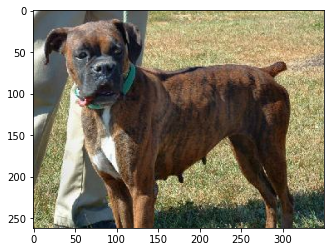

In [4]:
for image, label in raw_train.take(1):
  plt.imshow(image)
  print(label.numpy())

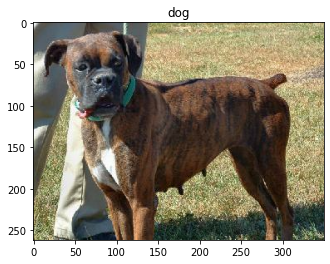

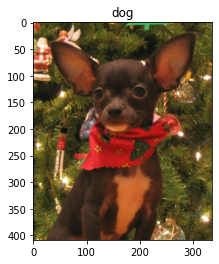

In [5]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [6]:
get_label_name


<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=2)>

In [7]:
# 이미지 전처리
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [10]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


In [11]:
for image_batch, label_batch in train_batches.take(1):
  pass
image_batch.shape

TensorShape([32, 160, 160, 3])

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 1s 0us/step


In [13]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
prediction_batch

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[ 1.4382039 ],
       [-0.5116828 ],
       [ 1.7301762 ],
       [ 2.0846791 ],
       [ 1.4875367 ],
       [ 0.6044712 ],
       [ 0.5219115 ],
       [ 1.2240499 ],
       [ 0.74327683],
       [ 0.13531373],
       [ 0.8096127 ],
       [ 2.2659535 ],
       [-1.1347313 ],
       [ 0.6018089 ],
       [ 1.8588299 ],
       [ 0.28351942],
       [ 1.2623028 ],
       [ 0.37154967],
       [ 0.68377805],
       [ 0.38106126],
       [ 0.24300843],
       [ 0.8864748 ],
       [ 1.3000882 ],
       [-0.8041699 ],
       [ 0.519014  ],
       [ 0.9851271 ],
       [ 0.06921998],
       [-0.00936419],
       [ 1.9207859 ],
       [ 0.85498303],
       [ 0.1308489 ],
       [-0.34458166]], dtype=float32)>

In [22]:
model = tf.keras.Sequential([
                             base_model,
                             global_average_layer,
                             prediction_layer
])

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
initial_epochs = 10
validation_steps=20

loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)


20/20 [==============================] - 4s 76ms/step - loss: 0.8820 - accuracy: 0.4000


In [26]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 75s 120ms/step - loss: 0.2442 - accuracy: 0.8852 - val_loss: 0.0925 - val_accuracy: 0.9622
Epoch 2/10
582/582 [==============================] - 71s 119ms/step - loss: 0.0771 - accuracy: 0.9723 - val_loss: 0.0662 - val_accuracy: 0.9729
Epoch 3/10
582/582 [==============================] - 71s 119ms/step - loss: 0.0607 - accuracy: 0.9774 - val_loss: 0.0568 - val_accuracy: 0.9785
Epoch 4/10
582/582 [==============================] - 68s 113ms/step - loss: 0.0539 - accuracy: 0.9804 - val_loss: 0.0529 - val_accuracy: 0.9785
Epoch 5/10
582/582 [==============================] - 68s 114ms/step - loss: 0.0499 - accuracy: 0.9814 - val_loss: 0.0503 - val_accuracy: 0.9785
Epoch 6/10
582/582 [==============================] - 71s 118ms/step - loss: 0.0473 - accuracy: 0.9828 - val_loss: 0.0487 - val_accuracy: 0.9785
Epoch 7/10
582/582 [==============================] - 67s 112ms/step - loss: 0.0455 - accuracy: 0.9833 - val_loss: 0.0475 - val_ac

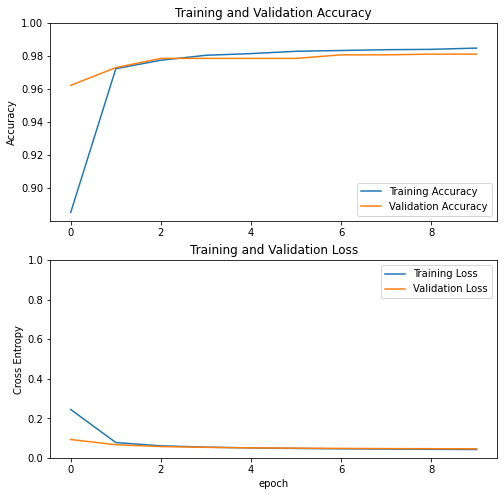

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
base_model.trainable = True
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers in the base model:  154


In [34]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [35]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [37]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_batches)

Epoch 10/20
582/582 [==============================] - 86s 135ms/step - loss: 0.0850 - accuracy: 0.9660 - val_loss: 0.0710 - val_accuracy: 0.9819
Epoch 11/20
582/582 [==============================] - 78s 131ms/step - loss: 0.0563 - accuracy: 0.9772 - val_loss: 0.0527 - val_accuracy: 0.9841
Epoch 12/20
582/582 [==============================] - 78s 130ms/step - loss: 0.0440 - accuracy: 0.9822 - val_loss: 0.0497 - val_accuracy: 0.9828
Epoch 13/20
582/582 [==============================] - 78s 130ms/step - loss: 0.0355 - accuracy: 0.9866 - val_loss: 0.0486 - val_accuracy: 0.9824
Epoch 14/20
582/582 [==============================] - 78s 130ms/step - loss: 0.0266 - accuracy: 0.9898 - val_loss: 0.0496 - val_accuracy: 0.9824
Epoch 15/20
582/582 [==============================] - 78s 131ms/step - loss: 0.0223 - accuracy: 0.9918 - val_loss: 0.0489 - val_accuracy: 0.9824
Epoch 16/20
582/582 [==============================] - 78s 130ms/step - loss: 0.0177 - accuracy: 0.9937 - val_loss: 0.0501 -

In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

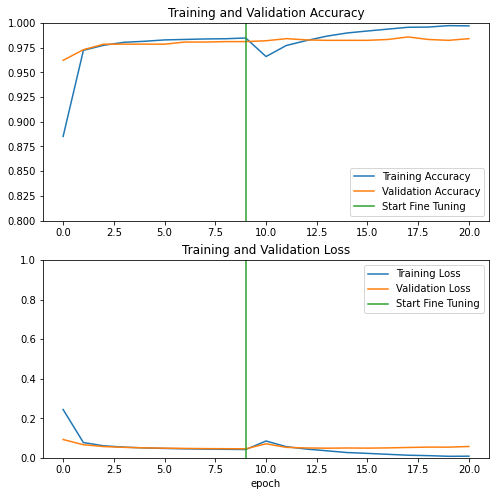

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1, initial_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 텐서플로 허브
### import와 설치

In [41]:
import matplotlib.pylab as plt

import tensorflow as tf

In [42]:
!pip install -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 109 kB 12.5 MB/s 


In [43]:
url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
classifier_url = url

In [45]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
                                  hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [46]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


73728/61306 [====================================] - 0s 0us/step


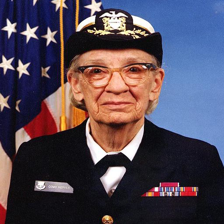

In [47]:
import numpy as np
import PIL.Image as Image

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg'
grace_hopper = tf.keras.utils.get_file('image.jpg', url)
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [48]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [49]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [51]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [52]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', url)
imagenet_labels = np.array(open(labels_path).read().splitlines())


24576/10484 [======================================================================] - 0s 0us/step


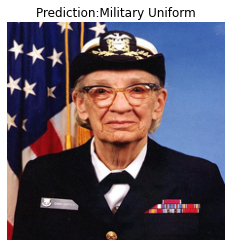

In [53]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Prediction:' + predicted_class_name.title())

# Flowers

In [54]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_root = tf.keras.utils.get_file(
    'flower_photos', url,
    untar=True
)


228827136/228813984 [==============================] - 5s 0us/step


In [56]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [57]:
for image_batch, label_batch in image_data:
  print('Image batch shape: ', image_batch.shape)
  print('Label batch shape: ', label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [58]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [59]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['hip', 'pot', 'daisy', 'daisy', 'daisy', 'mask', 'grocery store',
       'daisy', 'bee', 'chime', 'daisy', 'artichoke', 'corn', 'daisy',
       'daisy', 'mantis', "yellow lady's slipper", 'vase', 'bell pepper',
       'daisy', 'bakery', 'daisy', 'cardoon', 'daisy',
       "yellow lady's slipper", 'daisy', 'coral reef', 'garden spider',
       'sea urchin', 'daisy', 'bakery', 'bell pepper'], dtype='<U30')

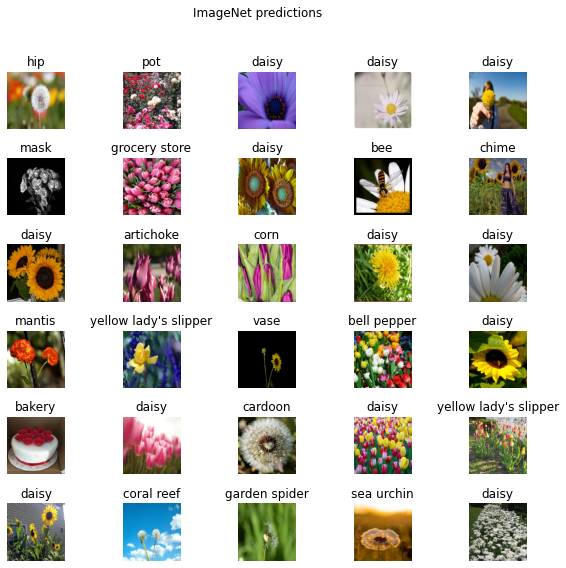

In [60]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle('ImageNet predictions')

In [66]:
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                          input_shape=(224,224,3))

In [67]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [68]:
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [69]:
predictions = model(image_batch)

In [70]:
predictions.shape

TensorShape([32, 5])

In [71]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [72]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
  
  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [73]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/2
115/115 [==============================] - 20s 143ms/step - loss: 0.3543 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 16s 139ms/step - loss: 0.3494 - acc: 0.8750


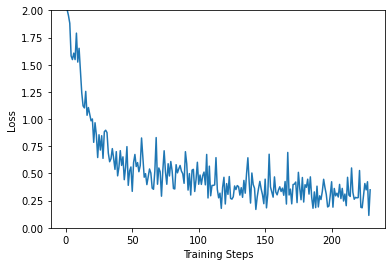

In [74]:
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

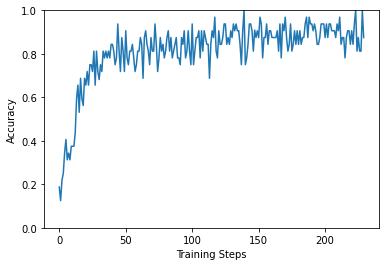

In [75]:
plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [76]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [77]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

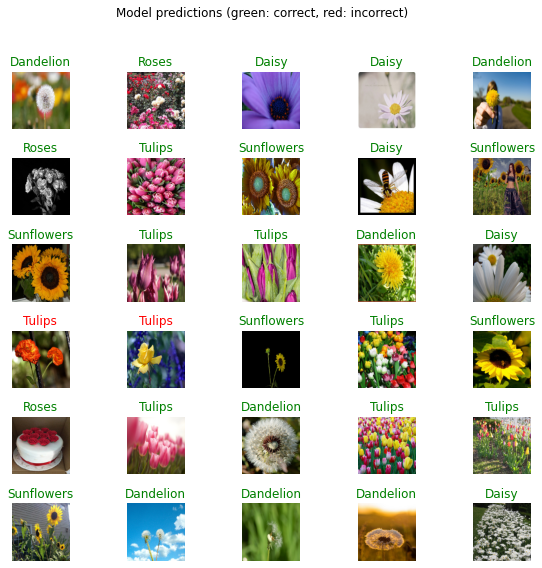

In [79]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_id[n] == label_id[n] else 'red'
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

In [80]:
import time
t = time.time()

export_path = '.{}'.format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: .1641956620/assets


INFO:tensorflow:Assets written to: .1641956620/assets


'.1641956620'

In [81]:
reloaded = tf.keras.models.load_model(export_path)


In [82]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [83]:
abs(reloaded_result_batch - result_batch).max()

0.0